In [216]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

import holidays
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [217]:
train = pd.read_csv(r'./data/train.csv')
international_trade = pd.read_csv(r'./data/international_trade.csv')
test = pd.read_csv(r'./data/test.csv')

In [218]:
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

def holiday(df):
    kr_holidays = holidays.KR()
    df['holiday'] = df.timestamp.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')
    return df['holiday']

def cyclical_feature(df, time=12):
    df['sin_time'] = np.sin(2*np.pi*df.month/time)
    df['cos_time'] = np.cos(2*np.pi*df.month/time)

In [219]:
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
# train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))
train['Weekday'] = pd.to_datetime(train['timestamp']).dt.weekday
train['is_weekend'] = train['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
train['total_item_value'] = train['item']+train['corporation']+train['location']
train['item_month_Weekday'] = train['item'].astype(str) + "_" + train['month'].astype(str) + train['Weekday'].astype(str)
train['corporation_weekday'] = train['corporation'].astype(str) + "_" + train['Weekday'].astype(str)

cyclical_feature(train)

test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
# test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))
test['Weekday'] = pd.to_datetime(test['timestamp']).dt.weekday
test['is_weekend'] = test['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['total_item_value'] = test['item']+test['corporation']+test['location']
test['item_month_Weekday'] = test['item'].astype(str) + "_" + test['month'].astype(str) + test['Weekday'].astype(str)
test['corporation_weekday'] = test['corporation'].astype(str) + "_" + test['Weekday'].astype(str)

cyclical_feature(test)


train['season'] = group_season(train)
test['season'] = group_season(test)

train['holiday'] = holiday(train)
test['holiday'] = holiday(test)

train['item_season'] = train['item'].astype(str) + "_" + train['season'].astype(str)
test['item_season'] = test['item'].astype(str) + "_" + test['season'].astype(str)

train['year_season'] = train['year'].astype(str) + "_" + train['season'].astype(str)
test['year_season'] = test['year'].astype(str) + "_" + test['season'].astype(str)



Q1 = train['price(원/kg)'].quantile(0.25)
Q3 = train['price(원/kg)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR
print(upper_bound)
train = train[(train['price(원/kg)'] >= lower_bound) & (train['price(원/kg)'] <= upper_bound)]



x = train.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
y = train['price(원/kg)']

x_test = test.drop(columns=['ID', 'timestamp'])

qual_col = ['item', 'corporation', 'location', 'season', 'holiday', 'total_item_value',
            'item_month_Weekday', 'corporation_weekday', 'item_season', 'year_season']

for i in qual_col:      
    le = LabelEncoder()
    x[i]=le.fit_transform(x[i])
    x_test[i]=le.transform(x_test[i])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1103)

6076.0


RMSE: 664.9854444782953


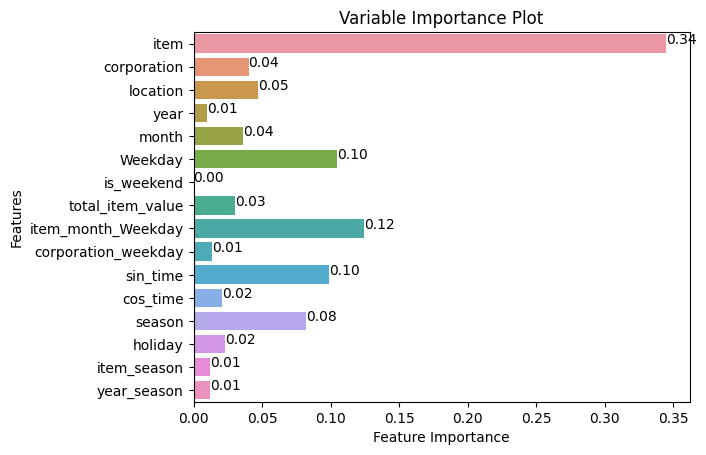

In [220]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_val)
rmse = mean_squared_error(y_val, xgb_pred, squared=False)
print(f"RMSE: {rmse}")

feature_importance = xgb.feature_importances_
for index, value in enumerate(feature_importance):
    plt.text(value, index, f'{value:.2f}')  # 소수점 둘째 자리까지 표시
sns.barplot(x=feature_importance, y=x_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot')
plt.show()

In [221]:
def cross_validate_models(folds, X, y, model):

    models = []
    scores = []
    for idx, (train_idx, val_idx) in enumerate(folds):
        print(f'===================================={idx+1}============================================')
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        model.fit(x_train, y_train, early_stopping_rounds=50,
                  eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)

        y_pred = model.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(f"{idx + 1} Fold RMSE = {rmse}")
        
        scores.append(rmse)
        models.append(model)
        print(f'================================================================================\n\n')
    
    print(f"Average RMSE over {len(folds)} folds: {sum(scores)/len(folds):.4f}")
    
    return models

model = XGBRegressor(n_estimators=10000, random_state=1103)
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1103).split(x, y))
models = cross_validate_models(folds, x, y, model)
predictions = sum(model.predict(x_test) for model in models) / len(folds)

====================================1============================================
1 Fold RMSE = 612.3969174301269


====================================2============================================
2 Fold RMSE = 664.7360803561158


====================================3============================================
3 Fold RMSE = 668.1900055795154


====================================4============================================
4 Fold RMSE = 663.0781637550702


====================================5============================================
5 Fold RMSE = 657.7053168248198


====================================6============================================
6 Fold RMSE = 648.337983004698


====================================7============================================
7 Fold RMSE = 653.4233707465868


====================================8============================================
8 Fold RMSE = 644.0883275917304


====================================9====================================

In [222]:
predictions

array([3496.7437 , -242.84464, 3388.8423 , ...,  528.1222 ,  512.8326 ,
        522.0611 ], dtype=float32)

In [223]:
submission = pd.read_csv(r'data\sample_submission.csv')
submission['answer'] = np.round(predictions)
idx_list = x_test[(x_test['Weekday'] == 6)].index
submission.loc[idx_list, 'answer'] = 0
submission.to_csv('./xgb_submission.csv', index=False)